In [16]:
# automatically apply changes in netgen
%load_ext autoreload
%autoreload 2

In [31]:
from time import sleep
import math
import random
# allows performing command-line operations from within Python
from subprocess import call, Popen

# tell jupyter notebook to show plots inline (with output)
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats.distributions import norm
import scipy.fftpack
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

# Utils

In [7]:
# from Knuth
def PoissonSample(mean = 1):
    L = math.exp(-mean)
    k = 0
    p = 1
    while(p > L):
        k += 1
        p *= random.random()
    return k-1

In [18]:
# from Knuth
def PoissonSamples(mean = 1, count = 1):
    res = []
    for i in range(0,count):
        res.append(PoissonSample(mean))
    return res

In [161]:
def PoissonPmf(mean = 1, val = 0):
    return math.pow(mean, val) * math.exp(-mean) / math.factorial(val)

In [155]:
math.factorial(3)

6

(array([0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 7.000e+00, 2.500e+01,
        4.600e+01, 1.090e+02, 2.160e+02, 3.250e+02, 4.860e+02, 6.330e+02,
        8.610e+02, 9.220e+02, 1.019e+03, 1.023e+03, 9.510e+02, 8.260e+02,
        7.460e+02, 5.360e+02, 4.210e+02, 2.890e+02, 2.090e+02, 1.250e+02,
        1.030e+02, 5.800e+01, 3.000e+01, 1.200e+01, 1.000e+01, 5.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 39 Patch objects>)

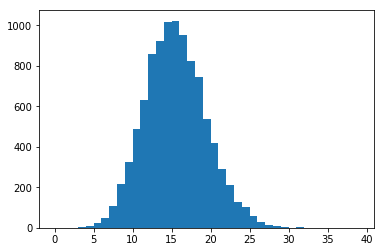

In [141]:
plt.hist(PoissonSamples(15,10000), bins = range(0,40))

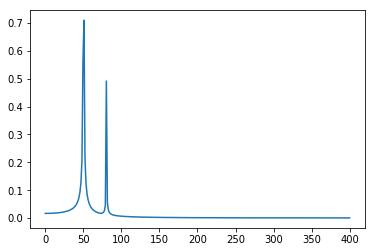

In [43]:
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

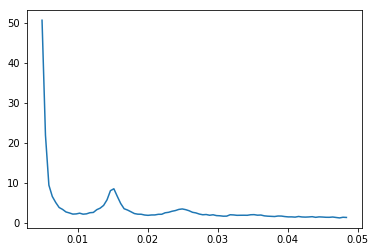

In [811]:
# number of samples
N = 2048
# sample spacing
T = 1
mean = 100
x = np.linspace(0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
fpl = []
for fsn in range(100):
    fpl.append([])
    # y = [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1]
    pl = []
    for sn in range(1):
        pl.append([])
        while (len(pl[sn]) < N):
            pl[sn].extend([0]*PoissonSample(mean) + [1]*PoissonSample(mean))
        pl[sn] = pl[sn][:N]
    y = [sum(x) for x in zip(*pl)]
    y[:] = [x - sum(y) / len(y) for x in y]
    fpl[fsn] = scipy.fftpack.fft(y)
yf = [sum([abs(xx) for xx in x]) for x in zip(*fpl)]
fig, ax = plt.subplots()
ax.plot([1*x for x in xf[10:100]], 2.0/N * np.abs(yf[10:100]))
plt.show()


In [331]:
def GenSeq(N=16, mean=1):
    seq = []
    while (len(seq) < N):
        seq.extend([0]*PoissonSample(mean) + [1]*PoissonSample(mean))
    return seq[:N]

In [396]:
def InjectNoise(seq, p):
    res = [0] * len(seq)
    for i in range(0,len(seq)):
        if random.random() < p:
            res[i] = seq[i]
        else:
            res[i] = 1 - seq[i]
    return res

InjectNoise([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1], .85)

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]

In [680]:
def ShannonEntropy(dist):
    # return entropy in bits
    
    listsum = sum(dist)
    entropy = 0
    for i in range(0,len(dist)):
        if dist[i] > 0:
            entropy += -dist[i]/listsum*math.log(dist[i]/listsum,2)
    return entropy
    #return -math.log(max(dist)/listsum, 2);

ShannonEntropy([.5,.5,0])

1.0

# AI

So my logic here is that there's three state variables to estimate:

- Conflict parameter, AKA the probability of reward for correct option and (1-p) is probability of reward for incorrect option
- Volatility, which is the lambda parameter of a poisson distribution
- How many trials have passed since the previous flip, which is important to estimate because the flip probability increased dramatically as n approached lambda.  Each group of trials between flips in known as an epoch

Conflict and volatility are constant throughout a set of epochs, so performance depends on how quickly the algorithm can identify the correct values. It is worth looking at the performance of the AI both when it is given an uninformitive prior and when it's given a completely informative prior for conflict and volatility. It is presumed that a human will enter the experiment with a prior better than completely uninformative, but that the human and AI should converge to the same (correct) estimates over time.  By looking at how performance improves over time we could possibly determine how rapidly the human converges vs the AI.

Estimating the length of the current epoch is the part which requires continual learning.



In [843]:
p = 0.65 # conflict
mean = 25 # volatility

# seq = [1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0]

epochs = GenSeq(4000,25)
seq = InjectNoise(epochs, 0.65)
init = seq[0]
seq = seq[1:]


ep_starts = []
for i in range(mean,len(epochs)):
    if(epochs[i] != epochs[i-1]):
        ep_starts.append(i-1)

trials = len(seq)
boxval = [0]*trials # probability that box 1 is the best box to pick
boxexp = [0]*trials # expected value of box 1
guess = [0]*trials # which box is guessed
st_en = [0]*trials # state entropy, total untertainty about current condition
ch_en = [0]*trials # choice entropy, uncertainty in which box is best choice
bx_en = [0]*trials # box entropy, uncertainty in which box will have prize this trial
ev_en = [0]*trials # event entropy, uncertainty in which of four kinds of events just occurred
avst_en = [0]*trials # expected state entropy, uncertainty of what state is about to become
avev_en = [0]*trials # expected event entropy, uncertainty in which of 4 events will happen next
avch_en = [0]*trials # expected choice entropy, uncertainty of what move to do after this move
lrn_st = [0]*trials # state-based learning
lrn_ch = [0]*trials # choice-based learning, how much did I learn about which choice is correct
acc = [0]*trials # accuracy, 1 = correct, 0 = incorrect

maxlen = mean * 3

state = [0] * 2 * maxlen
state[0] = init*(1-p) + (1-init)*p
state[1] = (1-init)*(1-p) + init*p

print(state)

marg = [0] * (maxlen+1)
remaining = 1
for i in range(0,len(marg)):
    pmf = PoissonPmf(mean, i)
    marg[i] = pmf / remaining
    remaining -= pmf

for trial in range(0,trials):
    st_en[trial] = ShannonEntropy(state)
    if trial > 0:
        lrn_st[trial] = avst_en[trial-1] - st_en[trial]
    psum = 0 # probability that box 1 is the best box to pick
    for i in range(0,len(state)):
        curbox = i % 2
        curlen = (i - curbox) // 2 + 1
        psum += state[i] * ((1-curbox) * marg[curlen] + curbox*(1-marg[curlen]))
    boxval[trial] = psum
    guess[trial] = math.floor(psum+0.5) # which box to pick
    ch_en[trial] = ShannonEntropy([psum,1-psum])
    if trial > 0:
        lrn_ch[trial] = avch_en[trial-1] - ch_en[trial]
    box_p = psum*p + (1-psum)*(1-p) # probability that box 1 will be the one with the prize
    boxexp[trial] = box_p
    bx_en[trial] = ShannonEntropy([box_p,1-box_p])
    
    trans = [[0 for i in range(2 * maxlen)] for j in range(2)]
    events = [[0 for i in range(4)] for j in range(2)]
    
    for truth in range(0,2):
        for i in range(0,len(state)):
            curbox = i % 2
            curlen = (i - curbox) // 2 + 1
            if truth == curbox:
                # either the sequence is extended or a swap occured but was covered up by noise
                p_nonswap = (1-marg[curlen])*p
                p_hidden_swap = marg[curlen]*(1-p)
                #norm = p_nonswap + p_hidden_swap
                p_nonswap *= state[i] #/ norm
                p_hidden_swap *= state[i] #/ norm
                trans[truth][1-curbox] += p_hidden_swap
                events[truth][0] += p_hidden_swap
                nextlen = i
                if i < len(state) - 2:
                    nextlen += 2
                trans[truth][nextlen] += p_nonswap
                events[truth][1] += p_nonswap
            if truth != curbox:
                # either a swap occured or the sequence was covered up by noise
                p_hidden_nonswap = (1-marg[curlen])*(1-p)
                p_swap = marg[curlen]*p
                #norm = p_hidden_nonswap + p_swap
                p_hidden_nonswap *= state[i] #/ norm
                p_swap *= state[i] #/ norm
                trans[truth][1-curbox] += p_swap
                events[truth][2] += p_swap
                nextlen = i
                if i < len(state) - 2:
                    nextlen += 2
                trans[truth][nextlen] += p_hidden_nonswap
                events[truth][3] += p_hidden_nonswap
        trans[truth][:] = [x / sum(trans[truth]) for x in trans[truth]] # normalize
            
    avg_trans = [(1-p)*x[0]+p*x[1] for x in zip(*trans)]
    avg_events = [(1-p)*x[0]+p*x[1] for x in zip(*events)]
    avst_en[trial] = ShannonEntropy(avg_trans)
    avpsum = 0 # probability that box 1 is the best box to pick next turn
    for i in range(0,len(avg_trans)):
        curbox = i % 2
        curlen = (i - curbox) // 2 + 1
        avpsum += avg_trans[i] * ((1-curbox) * marg[curlen] + curbox*(1-marg[curlen]))
    avch_en[trial] = ShannonEntropy([avpsum,1-avpsum])
    avev_en[trial] = ShannonEntropy(avg_events)
    
    sample = seq[trial]
    
    if guess[trial] == epochs[trial+1]:
        acc[trial] = 1
    
    if trial < trials - 1:
        ev_en[trial+1] = ShannonEntropy(events[sample])
    state[:] = trans[sample]
    #print(state)

[0.65, 0.35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[27, 50, 72, 97, 121, 156, 193, 217, 246, 269, 294, 313, 344, 374, 396, 419, 444, 464, 502, 524, 552, 574, 597, 628, 656, 673, 694, 723, 746, 770, 792, 821, 842, 860, 888, 909, 925, 948, 970, 997, 1020, 1051, 1068, 1090, 1113, 1131, 1161, 1185, 1212, 1235, 1267, 1289, 1322, 1347, 1370, 1398, 1428, 1449, 1470, 1498, 1520, 1556, 1578, 1602, 1628, 1650, 1675, 1694, 1722, 1747, 1774, 1803, 1823, 1848, 1876, 1899, 1923, 1940, 1963, 1978, 1997, 2022, 2044, 2069, 2094, 2111, 2137, 2166, 2179, 2206, 2226, 2246, 2279, 2308, 2336, 2369, 2393, 2419, 2446, 2479, 2509, 2538, 2566, 2594, 2620, 2642, 2673, 2699, 2723, 2741, 2757, 2786, 2815, 2844, 2866, 2889, 2917, 2945, 2972, 2994, 3024, 3047, 3074, 3104, 3119, 3146, 3167, 3196, 3220, 3241, 3268, 3298, 3323, 3352, 3373, 3403, 3425, 3457, 3487, 3517, 3537, 3559, 3581, 3608, 3634, 3650, 3678, 3693, 3716, 3742, 3767, 3795, 3827, 3844, 3877, 3894, 3915, 3940, 3965, 3993]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
[0, 1, 1, 

(0, 10)

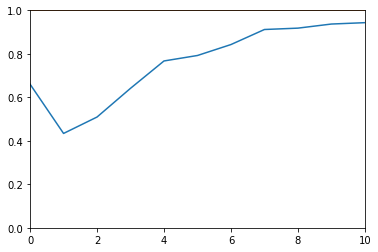

In [845]:
print(ep_starts)
dataruns = []
maxlen = 0
for i in range(0, len(ep_starts)-1):
    start = ep_starts[i] - 1
    runlen = ep_starts[i+1] - start
    if runlen > maxlen:
        maxlen = runlen
    #print(start,runlen)
    run = [acc[i] for i in range(start,start+runlen)]
    dataruns.append(run)
    if i < 10:
        print([guess[i] for i in range(start,start+runlen)])
        print(run)
        print()

    
counts = []
means = [0] * maxlen
stderrs = [0] * maxlen
meanup = [0] * maxlen
meanlow = [0] * maxlen
for i in range(0,maxlen):
    total = 0
    count = 0
    for run in dataruns:
        if len(run) > i:
            count += 1
            total += run[i]
    means[i] = total / count
    counts.append(count/len(dataruns))
    #alpha = 2 + total
    #beta = 2 + count - total
    #stderrs[i] = math.sqrt( (alpha*beta) / (math.pow(alpha+beta,2)*(alpha+beta+1)) / (alpha+beta))
    stderrs[i] = 0.5 * math.sqrt(1/count)
    meanup[i] = means[i] + stderrs[i]
    meanlow[i] = means[i] - stderrs[i]

plt.plot(means)
plt.plot(counts)
#plt.plot(meanup)
#plt.plot(meanlow)
plt.ylim(0,1)
plt.xlim(0,10)

In [846]:
sum(acc)/len(acc)

0.8187046761690423

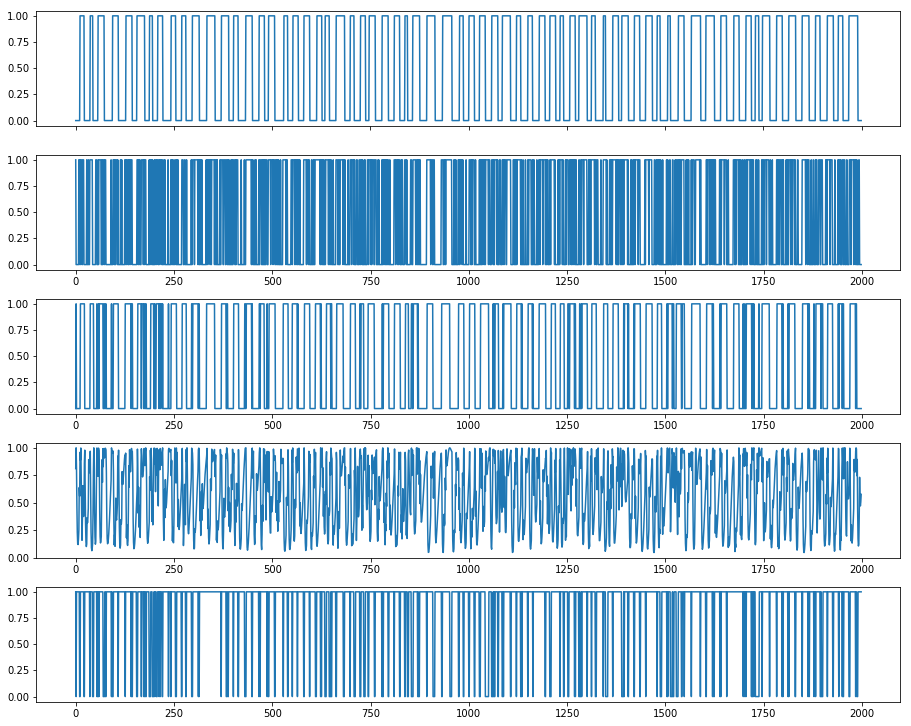

In [816]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 2, 2, 0.4],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 1.5, 2, 0.4])
ax3 = fig.add_axes([0.1, 1, 2, 0.4])
ax4 = fig.add_axes([0.1, 0.5, 2, 0.4])
ax5 = fig.add_axes([0.1, 0, 2, 0.4])


ax1.plot(epochs)
ax2.plot(seq)
ax3.plot(guess)
ax4.plot(ch_en)
ax5.plot(acc)

(400, 650)

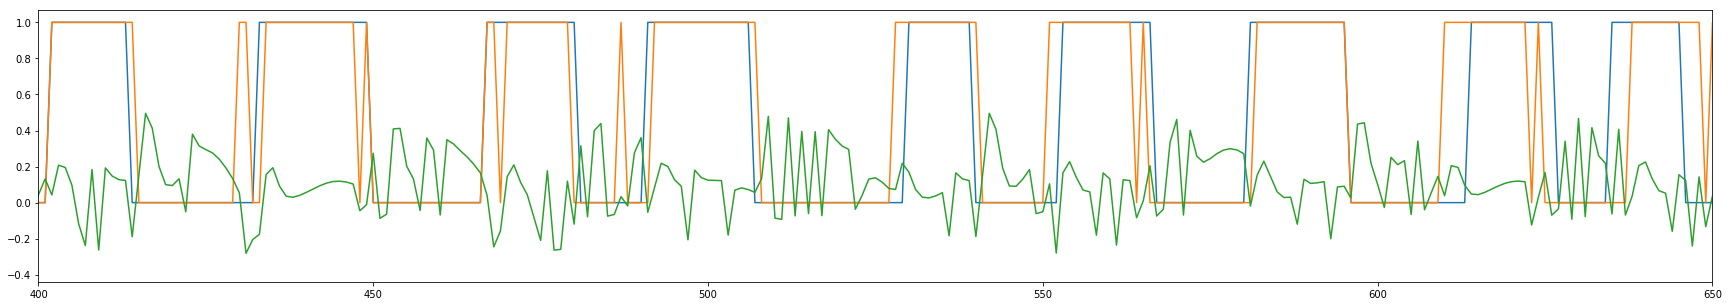

In [828]:
plt.figure(figsize=(30,5))
#plt.plot(st_en)
#plt.plot(ch_en)
#plt.plot(avst_en)
plt.plot(epochs)
#plt.plot(seq)
plt.plot(guess)
#plt.plot(ch_en)
plt.plot(lrn_ch)
plt.xlim(400,650)

In [287]:
mean = 15
maxlen = mean * 3
p = .85

state = [0] * 2 * maxlen

marg = [0] * (maxlen+1)
remaining = 1
for i in range(0,len(marg)):
    pmf = PoissonPmf(mean, i)
    marg[i] = pmf / remaining
    remaining -= pmf

state[0] = .5
state[20+20] = .5

psum = 0
state_entropy = 0

for i in range(0,len(state)):
    curbox = i % 2
    curlen = (i - curbox) // 2 + 1
    # state[i]
    # print(curbox,curlen,state[i],marg[curlen])
    psum += state[i] * ((1-curbox) * marg[curlen] + curbox*(1-marg[curlen]))
    if state[i] > 0:
        state_entropy += -state[i] * math.log(state[i],2)

guess = math.floor(psum+0.5)
choice_entropy = -psum*math.log(psum,2) + -(1-psum)*math.log(1-psum,2)

box_p = psum*p + (1-psum)*(1-p)
box_entropy = -box_p*math.log(box_p,2) + -(1-box_p)*math.log(1-box_p,2)

print(guess,psum,choice_entropy, box_p, box_entropy, state_entropy)

for truth in range(0,2):
    for i in range(0,len(state)):
        curbox = i % 2
        curlen = (i - curbox) // 2 + 1
        if truth == curbox:
            # either the sequence is extended or a swap occured but was covered up by noise
            p_nonswap = (1-marg[curlen])*p
            p_hidden_swap = marg[curlen]*(1-p)
            norm = p_nonswap + p_hidden_swap
            p_nonswap *= state[i] / norm
            p_hidden_swap *= state[i] / norm
            trans[truth][1-curbox] += p_hidden_swap
            events[truth][0] += p_hidden_swap
            nextlen = i
            if i < len(state) - 2:
                nextlen += 2
            trans[truth][nextlen] += p_nonswap
            events[truth][1] += p_nonswap
        if truth != curbox:
            # either a swap occured or the sequence was covered up by noise
            p_hidden_nonswap = (1-marg[curlen])*(1-p)
            p_swap = marg[curlen]*p
            norm = p_hidden_nonswap + p_swap
            p_hidden_nonswap *= state[i] / norm
            p_swap *= state[i] / norm
            trans[truth][1-curbox] += p_swap
            events[truth][2] += p_swap
            nextlen = i
            if i < len(state) - 2:
                nextlen += 2
            trans[truth][nextlen] += p_hidden_nonswap
            events[truth][3] += p_hidden_nonswap
print()
print(trans[0])
print()
print(events[0])
print()
print(events[1])
print()
avg_trans = [(1-p)*x[0]+p*x[1] for x in zip(*trans)]
print(avg_trans)
print()
avg_events = [(1-p)*x[0]+p*x[1] for x in zip(*events)]
print(avg_events)
avg_trans_entropy = ShannonEntropy(avg_trans)
print(avg_trans_entropy)
avg_events_entropy = ShannonEntropy(avg_events)
print(avg_events_entropy)

sample = 1
actual_events_entropy = ShannonEntropy(events[sample])
print(events[sample])
print(actual_events_entropy)

state[:] = trans[sample]

0 0.17997201836095456 0.6800158285124318 0.2759804128526682 0.8499158589402436 1.0

[0.0, 0.04514011274876184, 0.49999959512762787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45486029212361034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.04514011274876184, 0.9548598872512382, 0.0, 0.0]

[0.0, 0.0, 0.380586126330904, 0.6194138736690961]

[0.0, 0.3302692242935827, 0.4999888887810616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16974188692535577, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [261]:
[0,0,1]+[0,3,0]

[0, 0, 1, 0, 3, 0]

In [822]:
marg

[3.059023205018258e-07,
 4.588536211171261e-06,
 3.441417949449325e-05,
 0.00017207681935501435,
 0.0006453991308109483,
 0.001937447819571588,
 0.004853022025871328,
 0.010450047221920793,
 0.01980075739086583,
 0.033667912485083766,
 0.052261401002940515,
 0.07519536177761262,
 0.1016368196451595,
 0.13054102839611179,
 0.16086485059697914,
 0.19170314902363692,
 0.22234616155261402,
 0.2522816450015134,
 0.28116830724097086,
 0.30879965593723224,
 0.335068904323191,
 0.35993944818569795,
 0.38342194255054307,
 0.40555739147499187,
 0.42640511638426126,
 0.44603443499672235,
 0.464519051198485,
 0.48193337248001783,
 0.49835017097304046,
 0.5138391660844934,
 0.5284662299367756,
 0.5422930070610927,
 0.5553768043343327,
 0.5677706526133994,
 0.5795234732164416,
 0.5906803043369271,
 0.6012825575740386,
 0.611368285102719,
 0.6209724450526206,
 0.6301271574374776,
 0.6388619461811689,
 0.6472039649065531,
 0.6551782055024723,
 0.6628076892188052,
 0.6701136400638817,
 0.6771156388457]

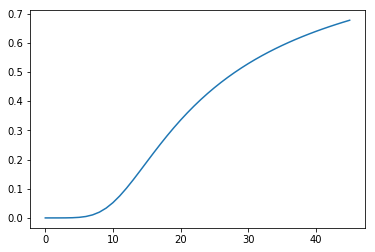

In [823]:
plt.plot(marg)